In [1]:
from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import hashlib

In [2]:
class ReflexiveMemory:
  def __init__(self):
    self.previous_sdr = None
    self.pairs = {}

  def add(self, sdr):
    current_sdr = '-'.join(map(str, sdr))
    if(self.previous_sdr != None):
      values = self.pairs.get(self.previous_sdr, {})
      pair_count = values.get(current_sdr, 0)
      pair_count = pair_count + 1
      if self.pairs.get(self.previous_sdr, None) is None:
        self.pairs[self.previous_sdr] = { current_sdr: pair_count }
      else:
        self.pairs[self.previous_sdr][current_sdr] = pair_count
    self.previous_sdr = current_sdr

  def predict(self, sdr):
    values = self.pairs.get(sdr, {})
    return_value = 0
    return_key = None
    for key, value in values.items():
      if value > return_value:
        return_value = value
        return_key = key
    return return_value, return_key


In [3]:
inputSources = [
    "hourly_numentaTM_speed_7578.csv",
    "hourly_numentaTM_iio_us-east-1_i-a2eb1cd9_NetworkIn.csv",
    "hourly_numentaTM_exchange-3_cpc_results.csv",
    "hourly_numentaTM_exchange-3_cpm_results.csv",
    "hourly_numentaTM_exchange-2_cpc_results.csv",
    "hourly_numentaTM_exchange-2_cpm_results.csv",
    "hourly_numentaTM_exchange-4_cpc_results.csv",
    "hourly_numentaTM_exchange-4_cpm_results.csv",
    "hourly_numentaTM_rogue_agent_key_hold.csv",
    "hourly_numentaTM_TravelTime_451.csv",
    "hourly_numentaTM_occupancy_6005.csv",
    "hourly_numentaTM_speed_t4013.csv",
    "hourly_numentaTM_TravelTime_387.csv",
    "hourly_numentaTM_occupancy_t4013.csv",
    "hourly_numentaTM_speed_6005.csv",
    "hourly_numentaTM_art_daily_flatmiddle.csv",
    "hourly_numentaTM_art_daily_jumpsdown.csv",
    "hourly_numentaTM_art_daily_jumpsup.csv",
    "hourly_numentaTM_art_daily_no_noise.csv",
    "hourly_numentaTM_art_daily_nojump.csv",
    "hourly_numentaTM_art_daily_perfect_square_wave.csv",
    "hourly_numentaTM_art_daily_small_noise.csv",
    "hourly_numentaTM_art_flatline.csv",
    "hourly_numentaTM_art_increase_spike_density.csv",
    "hourly_numentaTM_art_load_balancer_spikes.csv",
    "hourly_numentaTM_art_noisy.csv",
    "hourly_numentaTM_ec2_cpu_utilization_24ae8d.csv",
    "hourly_numentaTM_ec2_cpu_utilization_53ea38.csv",
    "hourly_numentaTM_ec2_cpu_utilization_5f5533.csv",
    "hourly_numentaTM_ec2_cpu_utilization_77c1ca.csv",
    "hourly_numentaTM_ec2_cpu_utilization_825cc2.csv",
    "hourly_numentaTM_ec2_cpu_utilization_ac20cd.csv",
    "hourly_numentaTM_ec2_cpu_utilization_c6585a.csv",
    "hourly_numentaTM_ec2_cpu_utilization_fe7f93.csv",
    "hourly_numentaTM_ec2_disk_write_bytes_c0d644.csv",
    "hourly_numentaTM_ec2_network_in_257a54.csv",
    "hourly_numentaTM_ec2_request_latency_system_failure.csv",
    "hourly_numentaTM_elb_request_count_8c0756.csv",
    "hourly_numentaTM_rds_cpu_utilization_cc0c53.csv",
    "hourly_numentaTM_rds_cpu_utilization_e47b3b.csv",
    "hourly_numentaTM_grok_asg_anomaly.csv",
    "hourly_numentaTM_ec2_disk_write_bytes_1ef3de.csv",
    "hourly_numentaTM_ec2_network_in_5abac7.csv",
    "hourly_numentaTM_rogue_agent_key_updown.csv",
    "hourly_numentaTM_ambient_temperature_system_failure.csv",
    "hourly_numentaTM_nyc_taxi.csv",
    "hourly_numentaTM_Twitter_volume_AMZN.csv",
    "hourly_numentaTM_Twitter_volume_FB.csv",
    "hourly_numentaTM_Twitter_volume_GOOG.csv",
    "hourly_numentaTM_Twitter_volume_KO.csv",
    "hourly_numentaTM_Twitter_volume_CVS.csv",
    "hourly_numentaTM_Twitter_volume_PFE.csv",
    "hourly_numentaTM_Twitter_volume_UPS.csv",
    "hourly_numentaTM_Twitter_volume_IBM.csv",
    "hourly_numentaTM_Twitter_volume_AAPL.csv",
    "hourly_numentaTM_Twitter_volume_CRM.csv",
    "hourly_numentaTM_cpu_utilization_asg_misconfiguration.csv",
    "hourly_numentaTM_machine_temperature_system_failure.csv",
#    "value1_pseudo_periodic_synthetic_1.csv",
#    "value1_pseudo_periodic_synthetic_2.csv",
#    "value1_pseudo_periodic_synthetic_3.csv",
#    "value1_pseudo_periodic_synthetic_4.csv",
#    "value1_pseudo_periodic_synthetic_5.csv",
#    "value1_pseudo_periodic_synthetic_6.csv",
#    "value1_pseudo_periodic_synthetic_7.csv",
#    "value1_pseudo_periodic_synthetic_8.csv",
#    "value1_pseudo_periodic_synthetic_9.csv",
#    "value1_pseudo_periodic_synthetic_10.csv",
#    "monthly_gold_prices.csv",
#    "monthly_sp500.csv",
#    "weekly_dow_jones.csv",
#    "weekly_nasdaq.csv",
#    "weekly_sp500.csv",
#    "monthly_vix_close.csv",
#    "monthly_vix_high.csv",
#    "monthly_vix_low.csv",
#    "monthly_vix_open.csv",
#    "daily_natural_gas.csv",
#    "daily_oil_prices.csv",
#    "value1_vix_close.csv",
#    "value1_vix_high.csv",
#    "value1_vix_low.csv",
#    "value1_vix_open.csv"
]

In [4]:

config = {
    'enc': {
        "value" :
            {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (2048,),
        'potentialPct': 0.8,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.0005,
        'synPermActiveInc': 0.003,
        'synPermConnected': 0.2,
        'boostStrength': 0.0,
        'wrapAround': True,
        'seed': 1956,
        'learn': False,
        'learnRows': 100 
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000}
}


In [5]:
input_path = pathlib.Path('../datasets/numenta')

pbar = tqdm(total=len(inputSources))
for dataset in inputSources:

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
    
    dateEncoder = DateEncoder(
        timeOfDay= config["enc"]["time"]["timeOfDay"], 
        weekend  = config["enc"]["time"]["weekend"]
    )
    
    scalarEncoderParams = RDSE_Parameters()
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoderParams.sparsity = config["enc"]["value"]["sparsity"]
    scalarEncoderParams.resolution = config["enc"]["value"]["resolution"]
    scalarEncoder = RDSE( scalarEncoderParams )
    # encodingWidth = (dateEncoder.size + scalarEncoder.size)
    encodingWidth = (scalarEncoder.size)


    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory()

    enc_info = Metrics( [encodingWidth], 999999999)
    sp_info = Metrics( sp.getColumnDimensions(), 999999999 )
    tm_info = Metrics( [tm.numberOfCells()], 999999999 )
    anomaly_history = AnomalyLikelihood(config["anomaly"]["period"])

    inputs = []
    anomaly = []
    anomalyProb = []
    for count, record in enumerate(records):

        dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
        consumption = float(record[1])
        inputs.append( consumption )
        
        dateBits = dateEncoder.encode(dateString)
        consumptionBits = scalarEncoder.encode(consumption)

        # encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
        encoding = SDR( consumptionBits )
        enc_info.addData( encoding )
        
        activeColumns = SDR( sp.getColumnDimensions() )

        if count < config['sp']['learnRows']:
            sp.compute(encoding, True, activeColumns)
        else: 
            sp.compute(encoding, config['sp']['learn'], activeColumns)
        sp_info.addData( activeColumns )

        rm.add(copy.deepcopy(activeColumns.sparse))

        tm.compute(activeColumns, learn=config['tm']['learn'])
        tm_info.addData( tm.getActiveCells().flatten() )
        
        anomaly.append( tm.anomaly )
        anomalyProb.append( anomaly_history.compute(tm.anomaly) )

    pbar.update(1)
    break

pbar.close()




  2%|▏         | 1/58 [00:01<01:09,  1.21s/it]


In [6]:
print("Encoded Input", enc_info)

Encoded Input SDR( 700 )
    Sparsity Min/Mean/Std/Max 0.0171429 / 0.0198756 / 0.000429027 / 0.02
    Activation Frequency Min/Mean/Std/Max 0 / 0.0198756 / 0.107903 / 0.940445
    Entropy 0.269547
    Overlap Min/Mean/Std/Max 0 / 0.685801 / 0.257529 / 1


In [7]:
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))

Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max 0.043956 / 0.0439559 / 3.43303e-07 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.043956 / 0.0660587 / 0.537778
    Entropy 0.759931
    Overlap Min/Mean/Std/Max 0 / 0.20711 / 0.300185 / 1
Spatial Pooler Connections:
    Inputs (700) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 595 / 595 / 595
    Connected Synapses on Segment Min/Mean/Max 236 / 290.694 / 330
    Synapses Dead (0.0917988%) Saturated (0.00269646%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0



In [8]:
print(dataset)

hourly_numentaTM_speed_7578.csv


In [9]:
print("Temporal Memory Cells", tm_info)
print(str(tm))


Temporal Memory Cells SDR( 21294 )
    Sparsity Min/Mean/Std/Max 0.00338123 / 0.0227017 / 0.014615 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.0227018 / 0.0297756 / 0.345778
    Entropy 0.833608
    Overlap Min/Mean/Std/Max 0 / 0.0678603 / 0.123728 / 0.90566
Temporal Memory Connections:
    Inputs (9705) ~> Outputs (21294) via Segments (16733)
    Segments on Cell Min/Mean/Max 0 / 0.785808 / 8
    Potential Synapses on Segment Min/Mean/Max 32 / 47.7293 / 64
    Connected Synapses on Segment Min/Mean/Max 27 / 40.8214 / 64
    Synapses Dead (0%) Saturated (0.0390382%)
    Synapses pruned (0.21326%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0



In [10]:
  print("Anomaly Mean", np.mean(anomaly))
  print("Anomaly Std ", np.std(anomaly))

Anomaly Mean 0.443469135115544
Anomaly Std  0.39104285466686683


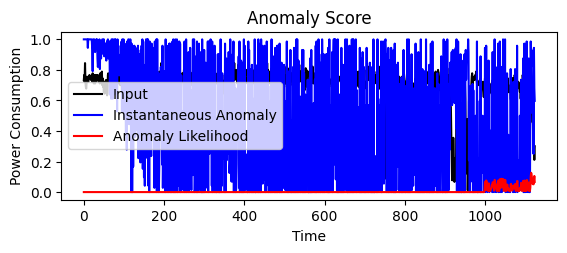

In [11]:
plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'black',
            np.arange(len(inputs)), anomaly, 'blue',
            np.arange(len(inputs)), anomalyProb, 'red',)
plt.legend(labels=('Input', 'Instantaneous Anomaly', 'Anomaly Likelihood'))
plt.show()


In [12]:
for key1, value1 in rm.pairs.items():
    for key2, value2 in value1.items():
        if value2 > 1:
            result = hashlib.md5(key1.encode())
            print(result.hexdigest(), end=' ')
            result = hashlib.md5(key2.encode())
            print(result.hexdigest(), end=' ')
            print(value2)

8c2f3d54f879bce845ec2bb884dc14f8 718ee4354dbba65ee2a8977852a7918d 12
8c2f3d54f879bce845ec2bb884dc14f8 5dfe648f0ce92d0b1e969f11b82e92f4 9
8c2f3d54f879bce845ec2bb884dc14f8 e7e6cc910e084784669e6d3045212383 5
8c2f3d54f879bce845ec2bb884dc14f8 8c2f3d54f879bce845ec2bb884dc14f8 8
8c2f3d54f879bce845ec2bb884dc14f8 e69ab9c73fca77213f58b6e0a9d3358f 4
8c2f3d54f879bce845ec2bb884dc14f8 b18c0b8a5a41c6473e828bd3176a977d 2
8c2f3d54f879bce845ec2bb884dc14f8 f8f5fe0dfd01f0e09319c14ba68379b0 2
8c2f3d54f879bce845ec2bb884dc14f8 47e25b58972df1aabc2288a0b790ea47 5
8c2f3d54f879bce845ec2bb884dc14f8 d5b78080a55d2277665301940cb70223 2
8c2f3d54f879bce845ec2bb884dc14f8 8de318fa9f8caa246623bf2cee4e2f12 3
8c2f3d54f879bce845ec2bb884dc14f8 091b4cd0fc9ddb118da9e55041ac22e9 3
718ee4354dbba65ee2a8977852a7918d 8c2f3d54f879bce845ec2bb884dc14f8 4
718ee4354dbba65ee2a8977852a7918d e7e6cc910e084784669e6d3045212383 4
718ee4354dbba65ee2a8977852a7918d 8de318fa9f8caa246623bf2cee4e2f12 6
718ee4354dbba65ee2a8977852a7918d 47e25b58972df1